In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
paper_dir             = config.get_property('paper_dir')


In [3]:
from utils.data_utils import load_movement_df, ward2size
from utils.plot_utils import *

path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df              = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))
movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data
ward2size                 = ward2size(movement_df)
ward2size                 = {r.ward_id: r.num_patients for idx_r, r in ward2size.iterrows()}

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_67491/1033347647.py:8: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data


In [4]:

admissions_df = movement_df.copy().reset_index(); admissions_df = admissions_df[admissions_df.first_day==1].rename(columns={"first_day": "num_admissions"})
admissions_df = admissions_df.groupby(["ward_id", "date"]).sum()[["num_admissions"]]#.unstack([0]).sum().stack().reset_index()
admissions_df = admissions_df.reset_index()
admissions_df["day_of_week"] = admissions_df.date.dt.dayofweek

dayofweek2day                     = {0: "Monday", 1: "Tuesday", 2:"Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
admissions_week_df                = admissions_df.groupby("date").sum().reset_index(); admissions_week_df["day_of_week"] = admissions_week_df.date.dt.dayofweek
admissions_week_df["day_of_week"] = admissions_week_df["day_of_week"].replace(dayofweek2day)

ward_size_df = movement_df.copy().reset_index()
ward_size_df["num_patients"]= 1
ward_size_df = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].unstack([-1]).resample("1D").sum().stack().reset_index()
ward_size_df["date_map"] = ward_size_df["date"].map(lambda x: x.strftime('%d-%b'))


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_67491/1158883548.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(ticksss)


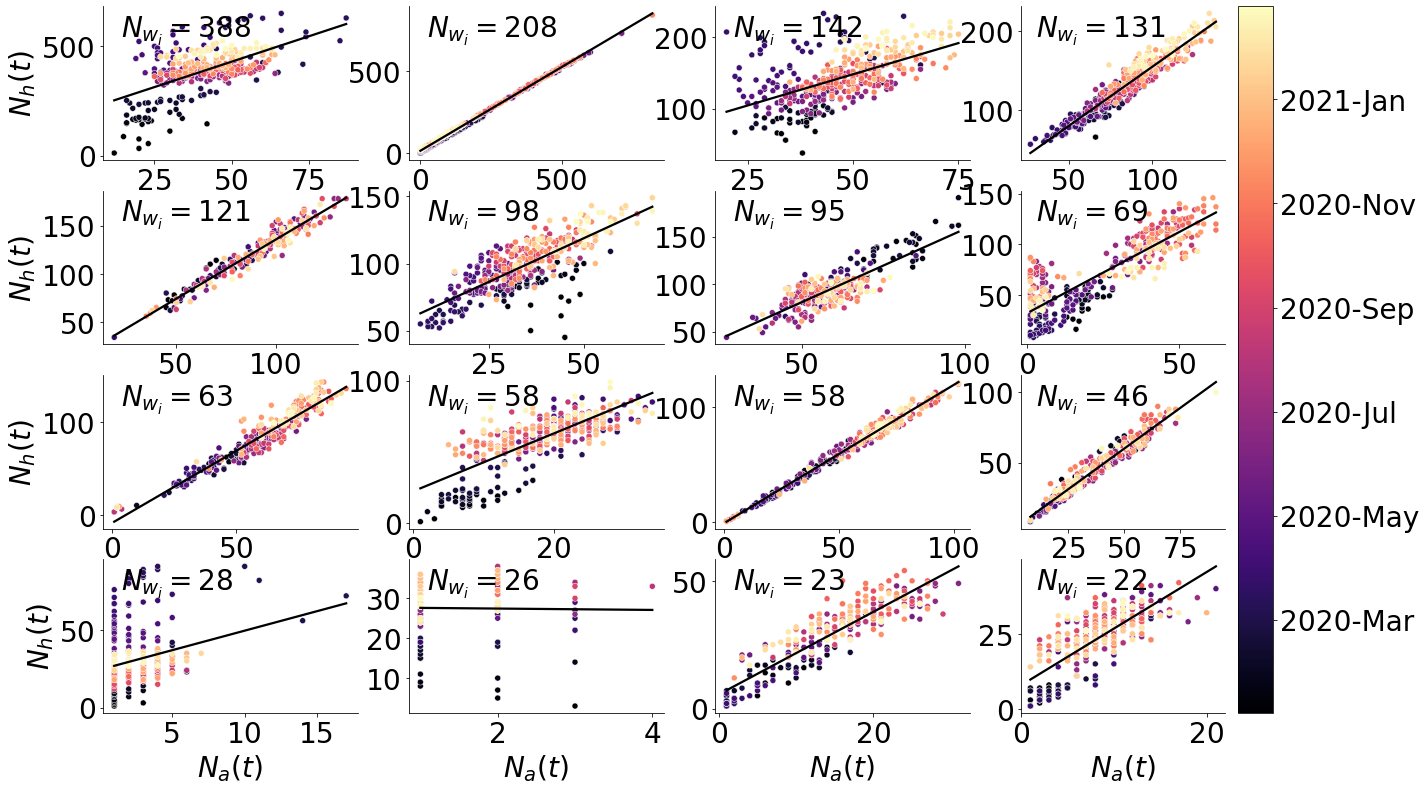

In [5]:
import seaborn as sns

all_ward_info_df = pd.merge(left=ward_size_df, right=admissions_df, how="inner")[["date", "ward_id", "num_patients", "num_admissions"]]
all_ward_info_df["ward_size"] = all_ward_info_df["ward_id"].map(ward2size)

all_ward_info_df["date_num"] = all_ward_info_df["date"].dt.strftime("%Y%m%d").astype(int)
top_10_big = np.flip(np.sort(all_ward_info_df.ward_size.unique()))

fig_dims = figure_size_setting(1900); fig_dims = [fig_dims[0], fig_dims[1]*1]

fig, axes = plt.subplots(4, 4, figsize=fig_dims)

PALETTE = "magma"#sns.light_palette("seagreen", as_cmap=True)

for idx_ward, ax in enumerate(axes.flatten()):

    sns.scatterplot(ax=ax, data=all_ward_info_df[all_ward_info_df.ward_size==top_10_big[idx_ward]], x ="num_admissions", y="num_patients", hue="date", palette=PALETTE, sizes=(10, 100), edgecolor="w")
    line_slope = sns.regplot(ax=ax, x="num_admissions", y="num_patients", data=all_ward_info_df[all_ward_info_df.ward_size==top_10_big[idx_ward]], scatter_kws={"s": 0}, ci=None, color="k")
    #ax.plot(range(10, 800), range(10, 800), lw=2, c="k", alpha=0.7)

    xlimsss = ax.get_xlim(); ylimsss = ax.get_ylim()

    ax.text(xlimsss[0]+(xlimsss[1]-xlimsss[0])/14, ylimsss[1]-(ylimsss[1]-ylimsss[0])/5, r"$N_{{w_i}}=${:.0f}".format(int(top_10_big[idx_ward])))
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_yscale("log")
    #ax.set_xscale("log")

axes[0,0].set_ylabel(r"$N_h(t)$")
axes[1,0].set_ylabel(r"$N_h(t)$")
axes[2,0].set_ylabel(r"$N_h(t)$")
axes[3,0].set_ylabel(r"$N_h(t)$")

axes[3, 0].set_xlabel(r"$N_a(t)$")
axes[3, 1].set_xlabel(r"$N_a(t)$")
axes[3, 2].set_xlabel(r"$N_a(t)$")
axes[3, 3].set_xlabel(r"$N_a(t)$")

norm = plt.Normalize(min(all_ward_info_df.date.unique()), max(all_ward_info_df.date.unique()))
sm   = plt.cm.ScalarMappable(cmap=PALETTE, norm=norm)
sm.set_array([])

cb      = fig.colorbar(sm, ax = axes[:,-1])
ticksss = [t.strftime("%Y-%b") for t in pd.to_datetime(cb.get_ticks())]
cb.set_ticklabels(ticksss)

#axes[0,0].legend(title="Date", loc="lower right", ncol=5, bbox_to_anchor=(3.5, 1.2))
#plt.tight_layout()

path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "AdmissionsVsInHospital_people.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)

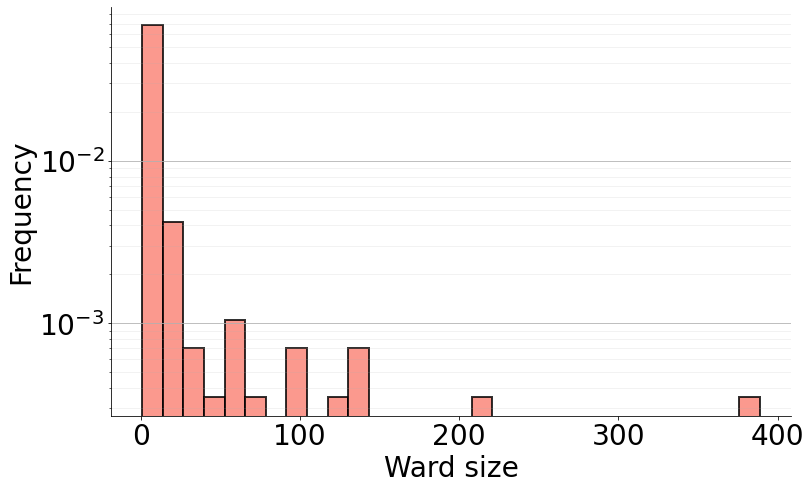

In [6]:
ward_size_df = movement_df.reset_index()
ward_size_df["num_patients"]= 1
ward_size_df = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df = ward_size_df.groupby("ward_id").mean().reset_index()

ward2size    = {r.ward_id: r.num_patients for idx, r in ward_size_df.iterrows()}

fig_dims = figure_size_setting(1100); fig_dims = [fig_dims[0], fig_dims[1]*1]

fig, ax = plt.subplots(1, 1, figsize=fig_dims)
ax.hist(ward_size_df[ward_size_df.num_patients>0].num_patients, bins=30, edgecolor="k", lw=2, facecolor="salmon", alpha=0.8, density=True, align="mid")
ax.set_yscale('log')
ax.set_xlabel("Ward size")
ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis="y")
ax.grid(axis="y", which="minor", alpha=0.2)


path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "WardSizeDistribution.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)


In [21]:
def return_category(ward_name):
    if ward_name.lower().__contains__("emergency") or ward_name.lower().__contains__("emer"):
        return "emergency"
    elif ward_name.lower().__contains__("cardiac") or ward_name.lower().__contains__("card"):
        return "cardiac"
    elif ward_name.lower().__contains__("infusion") or ward_name.lower().__contains__("inf"):
        return "infusion"
    elif ward_name.lower().__contains__("lab") or ward_name.lower().__contains__("laboratory"):
        return "laboratory"
    elif ward_name.lower().__contains__("ped") or ward_name.lower().__contains__("pediatric"):
        return "pediatric"
    elif ward_name.lower().__contains__("operating") or ward_name.lower().__contains__("operation"):
        return "operation"
    elif ward_name.lower().__contains__("radiation") or ward_name.lower().__contains__("radiation"):
        return "radiation"
    elif ward_name.lower().__contains__("nursery") or ward_name.lower().__contains__("nursery"):
        return "nursery"
    elif ward_name.lower().__contains__("icu") or ward_name.lower().__contains__("picu")or ward_name.lower().__contains__("nicu"):
        return "icu"
    else:
        return "other"

ward_size_df = movement_df.reset_index()
ward_size_df["num_patients"] = 1
ward_size_df = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward_size_df["building"] = ward_size_df["ward"].map(lambda x: x.split("-")[0])
ward_size_df["type"] = ward_size_df["ward"].map(lambda x: return_category(x))

#ward_size_df.iloc[::-1].to_csv(os.path.join(path_to_ms_figs, "WardSize.csv"))


types, t_counts = np.unique(ward_size_df.type, return_counts=True)
types = types[np.flip(np.argsort(t_counts))]

In [25]:
ward_size_df[ward_size_df.type=="other"].tail(30)

,ward,ward_id,num_patients,building,type
179,Mschony-Msch 4 Tower,103,3.449857,Mschony,other
32,Allen Hospital-Aln 3 River East,82,3.518519,Allen Hospital,other
50,Colum Business Unit-Cuimc Ed Telemedicine,10,3.597260,Colum Business Unit,other
126,Milstein Hospital-Mil 6 Garden North,140,3.867284,Milstein Hospital,other
185,Mschony-Msch 6 Tower,48,4.024242,Mschony,other
217,Vanderbilt Clinic-Vc 15 Col Dermapathology,67,4.102662,Vanderbilt Clinic,other
133,Milstein Hospital-Mil 7 Hudson South,113,4.319549,Milstein Hospital,other
195,Mschony-Msch Ld Procedures,52,4.358333,Mschony,other
220,Vanderbilt Clinic-Vcl 7os Col Oral Surg Fp,47,4.391304,Vanderbilt Clinic,other
191,Mschony-Msch 9 Tower,106,4.530026,Mschony,other


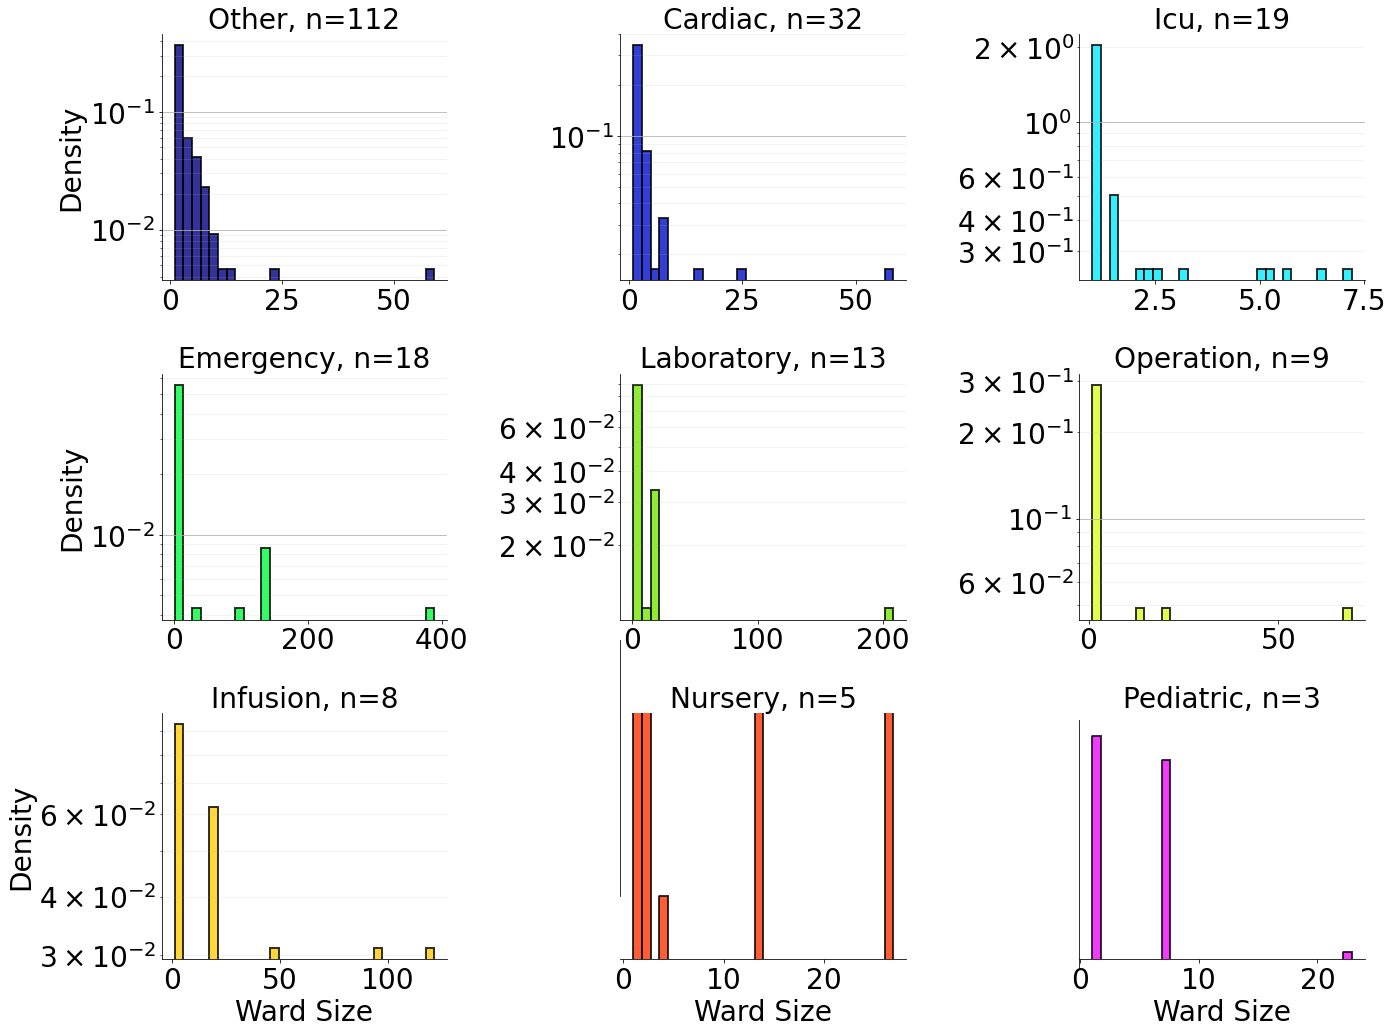

In [22]:
fig_dims = figure_size_setting(1100); fig_dims = [fig_dims[0], 12*1]
fig, ax = plt.subplots(3, 3, figsize=(20, 15))


typppp = ['other', 'cardiac', 'emergency', 'operation', 'laboratory', 'infusion', 'radiation', 'pediatric', 'nursery']
import pylab

c = pylab.get_cmap("gist_ncar")


for idx_c, axi in enumerate(ax.flatten()):
    if idx_c >= len(types):
        axi.remove()
        continue

    colorr = c(idx_c/len(types))

    w_df = ward_size_df[ward_size_df.type==types[idx_c]]

    axi.hist(w_df[w_df.num_patients>0].num_patients, bins=30, edgecolor="k", lw=2, facecolor=colorr, alpha=0.8, density=True, align="mid")
    axi.grid(axis="y", which="minor", alpha=0.2)
    axi.grid(axis="y")

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_yscale('log')
    axi.set_title(types[idx_c].capitalize()+ f", n={len(w_df)}")


ax[0, 0].set_ylabel("Density")
ax[1, 0].set_ylabel("Density")
ax[2, 0].set_ylabel("Density")


ax[-1, 0].set_xlabel("Ward Size")
ax[-1, 1].set_xlabel("Ward Size")
ax[-1, 2].set_xlabel("Ward Size")

plt.tight_layout()


path_to_save_fig  = os.path.join(os.path.join(paper_dir, "paper_01", "SupplementaryFigures"), "WardSizePerType.png")
fig.savefig(path_to_save_fig, dpi=300, transparent=True)
